In [ ]:
!pip install tensorflow

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import matplotlib.dates as mdates

In [ ]:
#creating a connection for the database
con = sqlite3.connect("db.sqlite3")

In [ ]:
#query to display all the tables
sql_query = """SELECT name FROM sqlite_master WHERE type='table';"""
cursor = con.cursor()
cursor.execute(sql_query)
print(cursor.fetchall())

[('django_migrations',), ('sqlite_sequence',), ('auth_group_permissions',), ('auth_user_groups',), ('auth_user_user_permissions',), ('django_admin_log',), ('django_content_type',), ('auth_permission',), ('auth_group',), ('auth_user',), ('companies_company',), ('companies_dailydata',), ('django_session',)]


In [ ]:
#query to read data from the table companies_dailydata
pd.read_sql_query("SELECT * from companies_dailydata", con)

,id,date,open,high,low,close,volume,created_at,updated_at,company_id
0,1,2010-01-04,15.615220,15.678981,15.547723,15.610239,78541293.0,2024-02-02 21:17:07.698665,2024-02-02 21:17:07.698665,3
1,2,2010-01-05,15.620949,15.637387,15.480475,15.541497,120638494.0,2024-02-02 21:17:07.705027,2024-02-02 21:17:07.705027,3
2,3,2010-01-06,15.588072,15.588072,15.102393,15.149715,159744526.0,2024-02-02 21:17:07.710074,2024-02-02 21:17:07.710074,3
3,4,2010-01-07,15.178109,15.193053,14.760922,14.797037,257533695.0,2024-02-02 21:17:07.713072,2024-02-02 21:17:07.713072,3
4,5,2010-01-08,14.744733,15.024933,14.672753,14.994298,189680313.0,2024-02-02 21:17:07.719599,2024-02-02 21:17:07.719599,3
...,...,...,...,...,...,...,...,...,...,...
34714,34715,2024-01-26,404.369995,406.170013,402.429993,403.929993,17803300.0,2024-02-02 21:26:46.770846,2024-02-02 21:26:46.770846,2
34715,34716,2024-01-29,406.059998,409.980011,404.329987,409.720001,24510200.0,2024-02-02 21:26:46.773720,2024-02-02 21:26:46.773720,2
34716,34717,2024-01-30,412.260010,413.049988,406.450012,408.589996,33477600.0,2024-02-02 21:26:46.776551,2024-02-02 21:26:46.776551,2
34717,34718,2024-01-31,406.959991,415.320007,397.209991,397.579987,47871100.0,2024-02-02 21:26:46.779000,2024-02-02 21:26:46.779000,2


In [ ]:
#query to read data from the table companies_company
pd.read_sql_query('SELECT * from companies_company',con)

,id,name,symbol
0,1,Apple Inc,AAPL
1,2,Microsoft Corporation,MSFT
2,3,Alphabet INC,GOOG
3,4,Amazon,AMZN
4,5,Nvidia corporation,NVDA
5,6,Meta Platforms,META
6,7,Tesla Inc,TSLA
7,8,Oracle Corporation,ORCL
8,9,Netflix Inc,NFLX
9,10,PepsiCo Inc,PEP


In [ ]:
#joining the two tables into one dataframe
data=pd.read_sql_query('''select company.name, company.symbol,
                  data.date, data.open, data.high, data.low, data.close, data.volume
                  from companies_company company join companies_dailydata data on company.id=data.company_id''',con)
data

,name,symbol,date,open,high,low,close,volume
0,Alphabet INC,GOOG,2010-01-04,15.615220,15.678981,15.547723,15.610239,78541293.0
1,Alphabet INC,GOOG,2010-01-05,15.620949,15.637387,15.480475,15.541497,120638494.0
2,Alphabet INC,GOOG,2010-01-06,15.588072,15.588072,15.102393,15.149715,159744526.0
3,Alphabet INC,GOOG,2010-01-07,15.178109,15.193053,14.760922,14.797037,257533695.0
4,Alphabet INC,GOOG,2010-01-08,14.744733,15.024933,14.672753,14.994298,189680313.0
...,...,...,...,...,...,...,...,...
34714,Microsoft Corporation,MSFT,2024-01-26,404.369995,406.170013,402.429993,403.929993,17803300.0
34715,Microsoft Corporation,MSFT,2024-01-29,406.059998,409.980011,404.329987,409.720001,24510200.0
34716,Microsoft Corporation,MSFT,2024-01-30,412.260010,413.049988,406.450012,408.589996,33477600.0
34717,Microsoft Corporation,MSFT,2024-01-31,406.959991,415.320007,397.209991,397.579987,47871100.0


In [ ]:
data['date']=pd.to_datetime(data['date'])

In [ ]:
data.dtypes

name              object
symbol            object
date      datetime64[ns]
open             float64
high             float64
low              float64
close            float64
volume           float64
dtype: object

In [ ]:
google_df=data[data.symbol=='GOOG']
google_df

,name,symbol,date,open,high,low,close,volume
0,Alphabet INC,GOOG,2010-01-04,15.615220,15.678981,15.547723,15.610239,78541293.0
1,Alphabet INC,GOOG,2010-01-05,15.620949,15.637387,15.480475,15.541497,120638494.0
2,Alphabet INC,GOOG,2010-01-06,15.588072,15.588072,15.102393,15.149715,159744526.0
3,Alphabet INC,GOOG,2010-01-07,15.178109,15.193053,14.760922,14.797037,257533695.0
4,Alphabet INC,GOOG,2010-01-08,14.744733,15.024933,14.672753,14.994298,189680313.0
...,...,...,...,...,...,...,...,...
3539,Alphabet INC,GOOG,2024-01-26,152.869995,154.110001,152.800003,153.789993,19494500.0
3540,Alphabet INC,GOOG,2024-01-29,153.639999,155.199997,152.919998,154.839996,20909300.0
3541,Alphabet INC,GOOG,2024-01-30,154.009995,155.039993,152.774994,153.050003,26578900.0
3542,Alphabet INC,GOOG,2024-01-31,145.389999,145.589996,141.550003,141.800003,43908600.0


In [ ]:
training_data=google_df[google_df.date<='2020-12-31']
training_set=training_data['close'].values.reshape(-1,1)
validation_data = google_df[(google_df.date>'2020-12-31') & (google_df.date<='2023-05-31')]
validation_set=validation_data['close'].values.reshape(-1,1)
test_data=google_df[google_df.date>'2023-05-31']
real_stock_price=test_data['close'].values.reshape(-1,1)

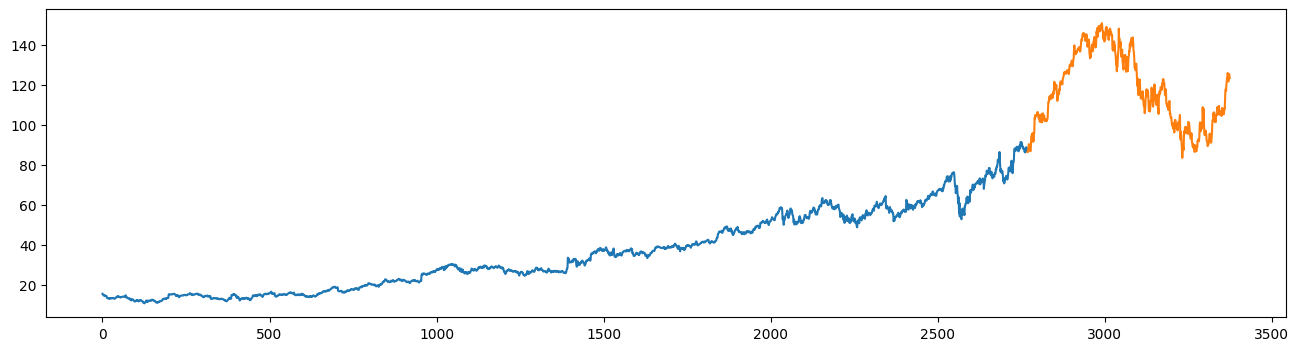

In [ ]:
plt.figure(figsize=(16,4))
plt.plot(training_data['close'])
plt.plot(validation_data['close'])
plt.show()

In [ ]:
#Feature scaling using MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
validation_set_scaled = sc.fit_transform(validation_set)


In [ ]:
#creating input sequences for training
def create_sequences(data,seq_length=60):
    X=[]
    y=[]
    for i in range(seq_length,len(data)):
        X.append(data[i-seq_length:i,0])
        y.append(data[i,0])
    return np.array(X), np.array(y)

In [ ]:
X_train,y_train = create_sequences(training_set_scaled)
X_validation,y_validation = create_sequences(validation_set_scaled)

#reshape inputs for LSTM model
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],1))
X_validation = np.reshape(X_validation,(X_validation.shape[0],X_validation.shape[1],1))

In [ ]:
#building the model
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

regressor = Sequential()

#first LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units=80,return_sequences=True))
regressor.add(Dropout(0.1))

regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=30))
regressor.add(Dropout(0.3))

regressor.add(Dense(units=1))

regressor.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
history = regressor.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation,y_validation))

Epoch 1/100
85/85 [==============================] - 10s 31ms/step - loss: 0.0104 - val_loss: 0.0098
Epoch 2/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0044 - val_loss: 0.0102
Epoch 3/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0040 - val_loss: 0.0091
Epoch 4/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0037 - val_loss: 0.0087
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0032 - val_loss: 0.0085
Epoch 6/100
85/85 [==============================] - 2s 21ms/step - loss: 0.0029 - val_loss: 0.0083
Epoch 7/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0029 - val_loss: 0.0077
Epoch 8/100
85/85 [==============================] - 1s 14ms/step - loss: 0.0025 - val_loss: 0.0078
Epoch 9/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0027 - val_loss: 0.0092
Epoch 10/100
85/85 [==============================] - 1s 15ms/step - loss: 0.0025 - val_loss: 0.007

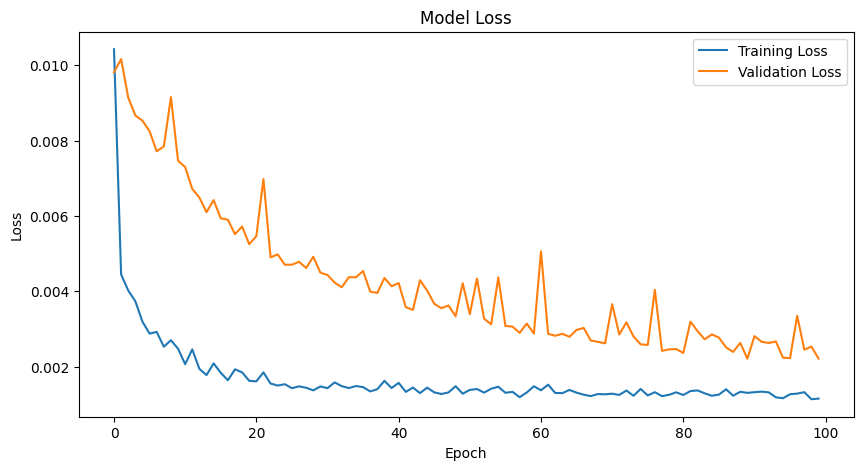

In [ ]:
# Plot loss and accuracy during training
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
test_data

,name,symbol,date,open,high,low,close,volume
3375,Alphabet INC,GOOG,2023-06-01,123.500000,125.040001,123.300003,124.370003,25017700.0
3376,Alphabet INC,GOOG,2023-06-02,124.489998,126.745003,124.349998,125.230003,19362400.0
3377,Alphabet INC,GOOG,2023-06-05,124.610001,127.989998,124.379997,126.629997,22672500.0
3378,Alphabet INC,GOOG,2023-06-06,126.599998,128.880005,125.970001,127.910004,19450100.0
3379,Alphabet INC,GOOG,2023-06-07,127.574997,129.550003,122.629997,122.940002,34179300.0
...,...,...,...,...,...,...,...,...
3539,Alphabet INC,GOOG,2024-01-26,152.869995,154.110001,152.800003,153.789993,19494500.0
3540,Alphabet INC,GOOG,2024-01-29,153.639999,155.199997,152.919998,154.839996,20909300.0
3541,Alphabet INC,GOOG,2024-01-30,154.009995,155.039993,152.774994,153.050003,26578900.0
3542,Alphabet INC,GOOG,2024-01-31,145.389999,145.589996,141.550003,141.800003,43908600.0


In [ ]:
#preparing test data
dataset_total = pd.concat((google_df[google_df.date<='2023-05-31']['close'], test_data['close']),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_data)-60:].values
inputs = inputs.reshape(-1,1)
inputs=sc.transform(inputs)
X_test=[]
for i in range(60, len(inputs)):
  X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

In [ ]:
#making predictions
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price=sc.inverse_transform(predicted_stock_price)

6/6 [==============================] - 1s 8ms/step


In [ ]:
len(predicted_stock_price)

169

In [ ]:
len(real_stock_price)

169

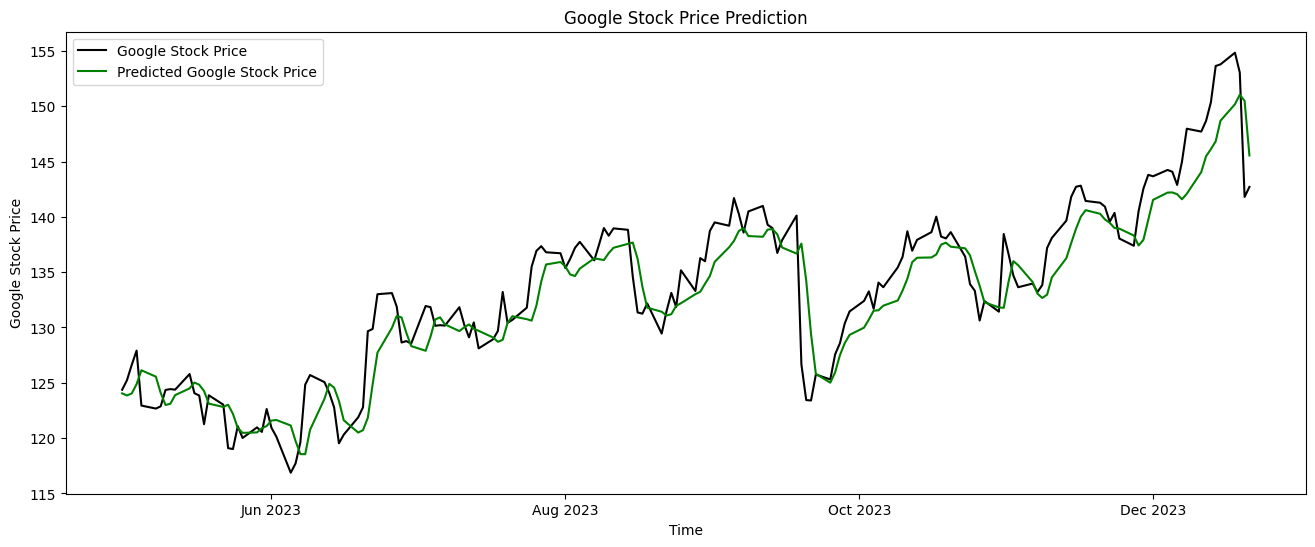

In [ ]:
date_range = pd.date_range(start='2023-05-01',periods=len(predicted_stock_price), freq='B')

#visualizing results with month and year on x-axis
plt.figure(figsize=(16, 6))
plt.plot(date_range, real_stock_price, color='black', label='Google Stock Price')
plt.plot(date_range, predicted_stock_price, color='green', label='Predicted Google Stock Price')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()